In [1]:
import os
import pickle
import pandas as pd
import re
import json

from mmfdl.util.data_gen_modify import tokenizer

In [2]:
def build_vocab_from_csv(csv_path, pkl_path, json_path, input_col='smiles'):
    """
    Generate vocabulary dictionary from csv
    
    Parameters:
    -----------
    csv_path : str
    vocab_path : str
    input_col : str
    """
    print(f'Building vocabulary dictionary from CSV file: {csv_path}')
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    if input_col not in df.columns:
        raise ValueError(f"Input column '{input_col}' not found in CSV. Available columns: {df.columns.tolist()}")
    
    smiles_list = df[input_col].dropna().tolist()
    # print(f'  Loaded {len(smiles_list)} SMILES from {csv_path}')

    char_dict = {}
    char_idx = 1
    
    for smi in smiles_list:
        if pd.isna(smi):
            continue
        try:
            tokens = tokenizer(smi)
            for tok in tokens:
                if tok not in char_dict:
                    char_dict[tok] = char_idx
                    char_idx += 1
        except Exception as e:
            print(f'  Error tokenizing SMILES: {smi}, error: {e}')
            continue
    
    for num in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
        if num not in char_dict:
            char_dict[num] = char_idx
            char_idx += 1
            # print(f'  Added number {num} to vocabulary')

    if 'unk' not in char_dict:
        char_dict['unk'] = char_idx
        char_idx += 1
        # print(f'  Added unk token to vocabulary (idx: {char_idx-1})')

    os.makedirs(os.path.dirname(pkl_path), exist_ok=True)
    os.makedirs(os.path.dirname(json_path), exist_ok=True)
    with open(pkl_path, 'wb') as f:
        pickle.dump(char_dict, f)
        
    with open(json_path, 'w') as f:
        json.dump(char_dict, f, indent=4)

    print(f'Vocabulary size: {len(char_dict)}')
    return char_dict

In [3]:
TDC_ROOT = "./../tdc/data/tdc_admet_all"
OUT_ROOT = "./data"
INPUT_COL = "smiles"

NUM_TOKENS = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
UNK_TOKEN = "unk"

In [4]:
def list_dataset_names(root_dir):
    """
    Args:
        root_dir (str): Root directory containing dataset folders.

    Returns:
        List[str]: List of dataset_name directory names.
    """
    return sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

In [5]:
def list_target_cols(dataset_dir):
    """
    Args:
        dataset_dir (str): Path to a dataset_name directory.

    Returns:
        List[str]: List of target_col names inferred from CSV filenames.
    """
    return sorted([
        os.path.splitext(f)[0]
        for f in os.listdir(dataset_dir)
        if f.endswith(".csv")
    ])

In [6]:
def update_special_tokens(vocab):
    """
    Args:
        vocab (Dict[str, int]): Existing SMILES vocabulary.

    Returns:
        bool: Whether the vocabulary was updated.
    """
    updated: bool = False
    max_idx: int = max(vocab.values()) if vocab else 0

    for tok in NUM_TOKENS:
        if tok not in vocab:
            max_idx += 1
            vocab[tok] = max_idx
            updated = True
            print(f"  Added number token '{tok}' (idx={max_idx})")

    if UNK_TOKEN not in vocab:
        max_idx += 1
        vocab[UNK_TOKEN] = max_idx
        updated = True
        print(f"  Added UNK token '{UNK_TOKEN}' (idx={max_idx})")

    return updated

In [7]:
vocab_sizes = []          # vocab size만 저장
vocab_records = []        # (dataset, target, size) 같이 저장하고 싶을 때 대비

dataset_names = list_dataset_names(TDC_ROOT)

for dataset_name in dataset_names:
    dataset_dir = os.path.join(TDC_ROOT, dataset_name)
    target_cols = list_target_cols(dataset_dir)

    # print(f"\n================ Dataset: {dataset_name} =================")

    for target_col in target_cols:
        # print(f"\n--- Target: {target_col} ---")

        raw_csv_path = os.path.join(
            TDC_ROOT, dataset_name, f"{target_col}.csv"
        )

        pkl_path = os.path.join(
            OUT_ROOT, dataset_name, target_col, "smiles_char_dict.pkl"
        )
        json_path = os.path.join(
            OUT_ROOT, dataset_name, target_col, "smiles_char_dict.json"
        )

        os.makedirs(os.path.dirname(pkl_path), exist_ok=True)

        # ------------------------------------------------------------
        # Case 1: Vocabulary already exists
        # ------------------------------------------------------------
        if os.path.exists(pkl_path):
            # print(f"Vocabulary exists: {pkl_path}")
            with open(pkl_path, "rb") as f:
                smiles_vocab = pickle.load(f)

            # print(f"Loaded vocab size: {len(smiles_vocab)}")

            updated = update_special_tokens(smiles_vocab)

            if updated:
                with open(pkl_path, "wb") as f:
                    pickle.dump(smiles_vocab, f)
                with open(json_path, "w") as f:
                    json.dump(smiles_vocab, f, indent=2)

                # print(f"Vocabulary updated → new size: {len(smiles_vocab)}")

        # ------------------------------------------------------------
        # Case 2: Create vocabulary from CSV
        # ------------------------------------------------------------
        else:
            # print(f"Creating vocabulary from CSV: {raw_csv_path}")

            smiles_vocab = build_vocab_from_csv(
                csv_path=raw_csv_path,
                pkl_path=pkl_path,
                json_path=json_path,
                input_col=INPUT_COL,
            )

            # print(f"Vocabulary created → size: {len(smiles_vocab)}")

        # ------------------------------------------------------------
        # Collect statistics
        # ------------------------------------------------------------
        vocab_size = len(smiles_vocab)
        vocab_sizes.append(vocab_size)
        vocab_records.append((dataset_name, target_col, vocab_size))

Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_AR_TRANS_dn.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_AR_TRANS_up.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_Ahr_CIS_dn.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_Ahr_CIS_up.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_BRE_CIS_dn.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_BRE_CIS_up.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_CAR_TRANS_dn.csv
Vocabulary size: 96
Building vocabulary dictionary from CSV file: ./../tdc/data/tdc_admet_all/ToxCast/ATG_CAR_TRANS_up.csv
Vocabulary size: 96
Building vocabulary dictio

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

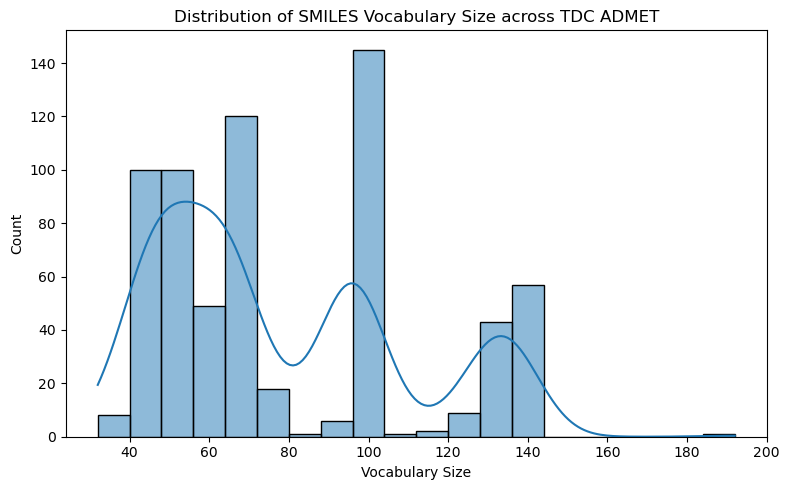

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(vocab_sizes, bins=20, kde=True)
plt.xlabel("Vocabulary Size")
plt.ylabel("Count")
plt.title("Distribution of SMILES Vocabulary Size across TDC ADMET")
plt.tight_layout()
plt.show()